In [1]:
##importing libraries that are need to support analysis
import pandas as pd
import numpy as np
from ebmdatalab import bq, maps, charts
import matplotlib.pyplot as plt
import os
import string

figures_path = os.path.join('..','figures/')

In [2]:
df = pd.read_csv(os.path.join("..","regression", "data_for_stata.csv"))
df.head()

,practice,pct,"('items', 0)","('items', 1)","('denominator', '')","('rate', '')",LSOA11NM,ruc11cd,RUC11,mean_percentile,...,Value_satisfaction,Value_long_term_health,Value_over_65,Value_under_18,code,dispensing_patients,total_items,list_size,ODS,supplier
0,A81001,00K,5243.0,5860.0,11103.0,0.527785,Stockton-on-Tees 014G,C,Urban city and town,0.445317,...,83.627562,49.450467,23.323544,20.264317,A81001,0.0,94138.0,4097.083333,A81001,TPP
1,A81002,00K,22703.0,38712.0,61415.0,0.630335,Stockton-on-Tees 014F,C,Urban city and town,0.493340,...,80.971049,58.535567,21.194615,18.908872,A81002,0.0,451497.0,19829.750000,A81002,TPP
2,A81003,00K,NaN,NaN,NaN,NaN,Hartlepool 007D,C,Urban city and town,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,A81004,00M,10306.0,16142.0,26448.0,0.610330,Middlesbrough 015C,C,Urban city and town,0.521257,...,87.585723,50.589328,18.819479,18.937531,A81004,0.0,214788.0,10307.333333,A81004,TPP
4,A81005,00M,1920.0,31762.0,33682.0,0.942996,Redcar and Cleveland 018A,C,Urban city and town,0.342573,...,84.936370,63.431023,27.956587,17.851796,A81005,0.0,195485.0,8020.416667,A81005,TPP


In [3]:
# prepare data for plotting
dfp = df.copy()[["('rate', '')", 'dispensing_patients', "supplier", "list_size"]]
dfp = dfp.rename(columns={"('rate', '')":'Proportion prescribed as 28 day durations'})

# explore list sizes to find ordinary practices
# there are many non-standard practices with no list size (null) that we want to exclude
# # also those with v small list sizes may be closing or otherwise unusual
dfp["list_size_group"] = "<100"
dfp.loc[pd.isnull(dfp["list_size"]), "list_size_group"] = "null"
dfp.loc[dfp["list_size"]>100, "list_size_group"] = ">100"

print (dfp.groupby("list_size_group")["list_size_group"].count())

# include only practices with >100 patients
dfp = dfp.loc[dfp["list_size"]>100]


list_size_group
<100      42
>100    7256
null    5628
Name: list_size_group, dtype: int64


dispensing_practice
no         6234
unknown      12
yes        1010
Name: dispensing_practice, dtype: int64


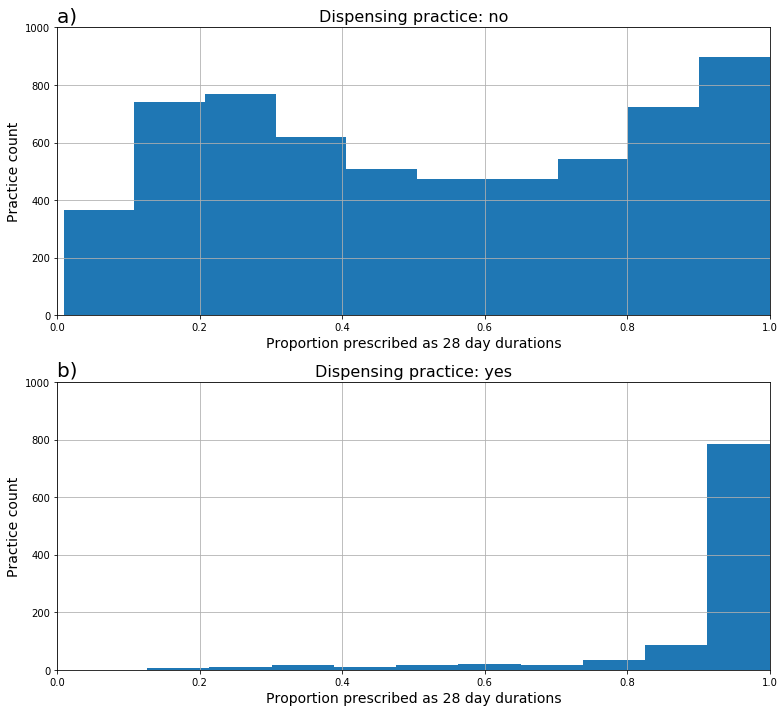

In [4]:
### Dispensing
dfp1 = dfp.copy()

# create binary field for dispensing practice, based on practice having dispensing patients
dfp1['dispensing_practice'] = "no"
dfp1.loc[pd.isnull(dfp1['dispensing_patients']),'dispensing_practice'] = "unknown" # temp value for unknown
dfp1.loc[dfp1['dispensing_patients']>=1,'dispensing_practice'] = "yes"
print (dfp1.groupby("dispensing_practice")["dispensing_practice"].count())

## reassign unknowns to non-dispensing
dfp1.loc[dfp1['dispensing_practice']=="unknown",'dispensing_practice'] = "no"

# reshape for plotting
dfp1 = dfp1[["Proportion prescribed as 28 day durations",'dispensing_practice']].set_index('dispensing_practice').stack()#.reset_index()


def draw_histograms(df, variables, n_rows, n_cols, title):
    fig=plt.figure(figsize=(n_rows*5+1, 10))
    for i, var_name in enumerate(variables):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        df[var_name].hist(bins=10,ax=ax)
        ax.set_title(string.ascii_lowercase[i]+") ", size=20, loc="left")
        ax.set_title("Dispensing practice: "+var_name, size=16)
        ax.set_ylabel("Practice count", size=14)
        ax.set_xlabel("Proportion prescribed as 28 day durations", size=14)
        ax.set_ylim([0,1000])
        ax.set_xlim([0,1])
    fig.tight_layout()  # Improves appearance a bit.
    
    
    plt.savefig(f"{figures_path}histogram_{title}.png", format="png", scale=2)
    plt.show()
    

draw_histograms(dfp1, ["no","yes"], 2, 1, "dispensing")

supplier
EMIS         4000
Microtest      37
TPP          2611
Unknown       344
Vision        264
Name: supplier, dtype: int64


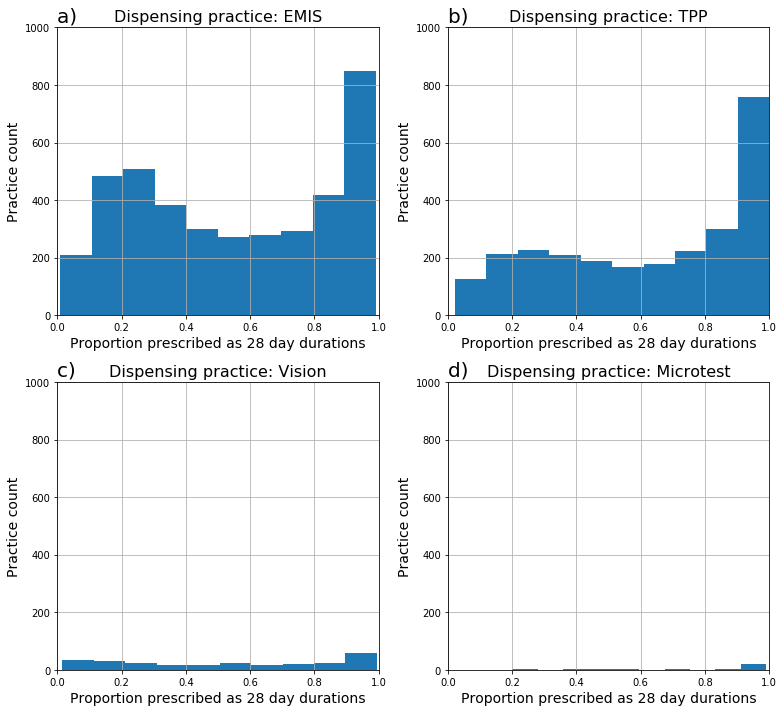

In [5]:
### Software supplier

dfp2 = dfp.copy()

# Prepare data - inspect missing suppliers
dfp2["supplier"] = dfp2["supplier"].fillna("Unknown")
print (dfp2.groupby("supplier")["supplier"].count())
# drop unknowns as these may be non-standard practices or their IDs were 
# simply misaligned with the software file - either way we have no way to categorise them.
dfp2 = dfp2.loc[dfp2["supplier"] != "Unknown"]

# reshape for plotting
dfp2 = dfp2[["Proportion prescribed as 28 day durations",'supplier']].set_index('supplier').stack()

draw_histograms(dfp2, ["EMIS", "TPP", "Vision", "Microtest"], 2, 2, "supplier")